In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

import torch.nn.functional as fun

import medmnist
from medmnist import INFO, Evaluator

from VAE import VAE

import os
from torchvision.utils import save_image
from PIL import Image
import torchvision.transforms as transforms

from pytorch_fid import fid_score

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

data_flag = 'bloodmnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load all splits
train = DataClass(split='train', transform=data_transform, download=True)
val = DataClass(split='val', transform=data_transform, download=True)
test = DataClass(split='test', transform=data_transform, download=True)

# Combine them into a single dataset
full_dataset = ConcatDataset([train, val, test])
dataloader = DataLoader(full_dataset, batch_size=128, shuffle=True)

train_dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test, batch_size=128, shuffle=True)

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = fun.mse_loss(recon_x, x, reduction='sum')
    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(train_dataloader, val_dataloader, test_dataloader, latent_dim=64)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss, val_loss = model.train(num_epochs=100, loss_function=loss_function, optimizer=optimizer)

Training loss(epoch 1) = 81.367
Validation loss(epoch 1) = 85455.221
Training loss(epoch 2) = 46.495
Validation loss(epoch 2) = 73897.103
Training loss(epoch 3) = 40.016
Validation loss(epoch 3) = 63388.245
Training loss(epoch 4) = 35.763
Validation loss(epoch 4) = 58863.091
Training loss(epoch 5) = 34.147
Validation loss(epoch 5) = 57329.491
Training loss(epoch 6) = 33.198
Validation loss(epoch 6) = 55831.610
Training loss(epoch 7) = 32.612
Validation loss(epoch 7) = 55045.259
Training loss(epoch 8) = 32.125
Validation loss(epoch 8) = 55046.452
Training loss(epoch 9) = 31.913
Validation loss(epoch 9) = 54890.560
Training loss(epoch 10) = 31.747
Validation loss(epoch 10) = 54126.546
Training loss(epoch 11) = 31.575
Validation loss(epoch 11) = 53849.807
Training loss(epoch 12) = 31.461
Validation loss(epoch 12) = 53406.954
Training loss(epoch 13) = 31.271
Validation loss(epoch 13) = 53507.106
Training loss(epoch 14) = 31.238
Validation loss(epoch 14) = 53271.395
Training loss(epoch 15) 

In [5]:
def show_images(images):
    """Display a batch of images (Tensor: N x 3 x 28 x 28)"""
    rows = int(images.shape[0] ** 0.5)
    print(images.shape[0])

    grid = make_grid(images, nrow=rows)

    plt.title('Generated images(VAE)')
    plt.imshow(F.to_pil_image(grid))
    plt.axis('off')
    plt.show()

def generate_images(model, latent_dim=64, n_samples=16):
    #model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim)  # Sample from standard normal
        generated = model.decode(z)
    return generated

def generate_and_save_images(model, latent_dim=64, n_samples=16, output_dir="generated_images"):
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim).to(device)
        generated = model.decode(z).cpu()  # Shape: (n_samples, 3, 28, 28)

    for i in tqdm(range(n_samples), 'Generating and saving %d fake images   ' % (n_samples)):
        img_tensor = generated[i]
        img_pil = transforms.ToPILImage()(img_tensor)  # Convert to PIL format
        img_pil.save(os.path.join(output_dir, f"sample_{i:03d}.png"))
        # Or use save_image(generated[i], path) if you prefer torchvision

16


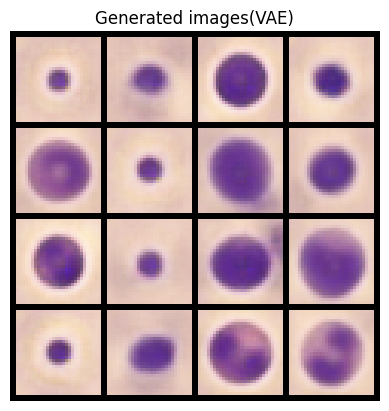

In [6]:
generated_images = generate_images(model, latent_dim=64, n_samples=16)
show_images(generated_images)

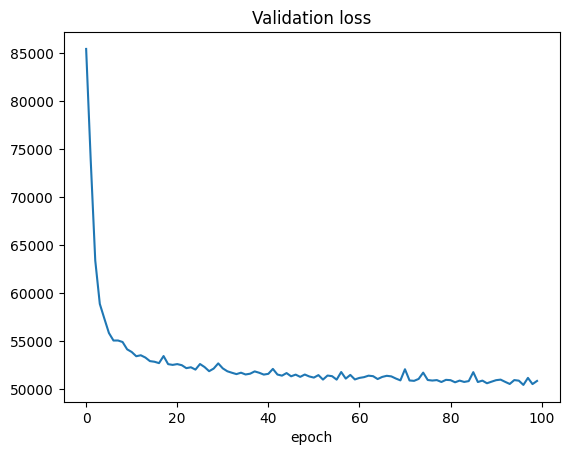

In [12]:
plt.plot(val_loss);
plt.title('Validation loss');
plt.xlabel('epoch');

In [13]:
def get_and_save_real_images():
    # Generate a random permutation of indices
    perm = torch.randperm(len(full_dataset))[:10000]

    # Convert to list if needed
    subset = Subset(full_dataset, perm.tolist())

    # Create a DataLoader for the subset
    new_dataloader = DataLoader(subset, batch_size=128, shuffle=True)

    # Folder to save images
    save_dir = "random_real_images"
    os.makedirs(save_dir, exist_ok=True)

    # Optional: transform tensor to PIL image
    to_pil = transforms.ToPILImage()

    image_counter = 0
    for k in tqdm(range(len(subset)), 'Saving 10000 random real images           '):
        pil_img = to_pil(subset[k][0])
        pil_img.save(os.path.join(save_dir, f"img_{image_counter:05d}.png"))
        image_counter += 1

In [9]:
get_and_save_real_images()
generate_and_save_images(model, latent_dim=64, n_samples=10000, output_dir='VAE_fake_images')

fid_value = fid_score.calculate_fid_given_paths(
    ['random_real_images', 'VAE_fake_images'],
    batch_size=1,
    device='cuda',
    dims=2048
)
print('FID:', fid_value)

100%|██████████| 10001/10001 [01:47<00:00, 93.44it/s]

FID: 0.340614257418165
